In [2]:
import pandas as pd

party_replace = {
    'PARTI KEADILAN RAKYAT (PKR)': 'PAKATAN HARAPAN (PH)',
    'PARTI TINDAKAN DEMOKRATIK (DAP)': 'PAKATAN HARAPAN (PH)',
    'PARTI ISLAM SE MALAYSIA (PAS)': 'PERIKATAN NASIONAL (PN)',
    'IKATAN DEMOKRATIK MALAYSIA (MUDA)': 'PAKATAN HARAPAN (PH)'
}

df = pd.read_csv('data/candidates_ge15.csv',usecols=['state','parlimen','party','result'])
df.party = df.party.replace(party_replace).fillna(df.party)
df = df[df.result == 1].drop('result',axis=1)
n_seats = df[['party']].groupby('party').size()
# df = df[~df.state.isin(['Sabah','Sarawak','W.P. Labuan'])] # to add East Msia, comment out this line
df.party = df.party.map(party_replace).fillna(df.party)
df['party_short'] = df.party.str.extract(r'\((\w+)\)')
party_abbr = dict(zip(df.party,df.party_short))
df = df.drop('party_short',axis=1)

vf = pd.read_csv('data/voters_ge15.csv',usecols=['state','parlimen','total'])\
    .rename(columns={'total':'voters'})\
        .groupby(['state','parlimen'])\
            .sum().reset_index()


df = pd.merge(df,vf,on=['state','parlimen'],how='left')
assert len(df[df.voters.isnull()]) == 0, 'Missing data!' # ensure complete merge
n_voters = (df[['party','voters']].groupby('party').mean()).to_dict()

df = df.sort_values(by='voters',ascending=False).reset_index(drop=True)

PH is coloured in zzz, with 82 seats and an average size of of 125,477 voters across these seats.
PN is coloured in zzz, with 74 seats and an average size of of 90,930 voters across these seats.
BN is coloured in zzz, with 30 seats and an average size of of 67,645 voters across these seats.


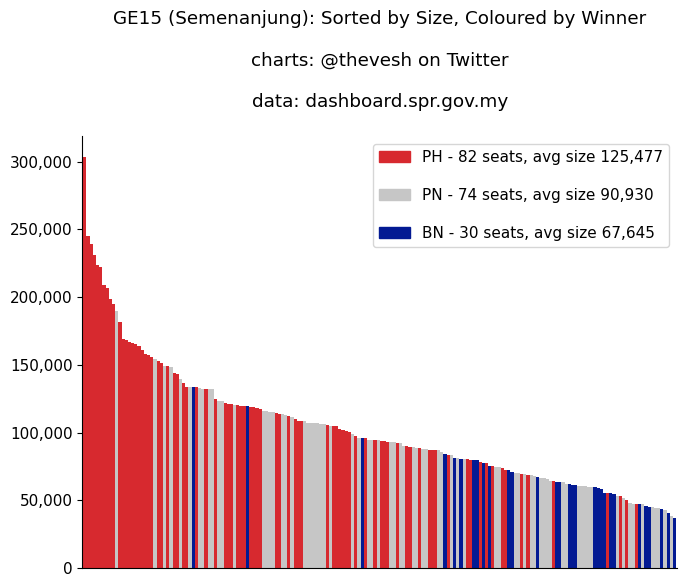

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as tkr

party_color = { # colors from SPR dashboard
    'PAKATAN HARAPAN (PH)':'#d7292f',
    'PERIKATAN NASIONAL (PN)':'#c6c6c6', # to ensure no red-green colour-blind clash
    'BARISAN NASIONAL (BN)':'#031a93',
    'GABUNGAN PARTI SARAWAK (GPS)': '#1f2c45',
    'PARTI GABUNGAN RAKYAT SABAH (GRS)': '#5bc5f0',
    'PARTI WARISAN SABAH (WARISAN)': '#5bc5f0',
    'BEBAS (BEBAS)': '#000000', 
    'PARTI KESEJAHTERAAN DEMOKRATIK MASYARAKAT (KDM)': '#000000',
    'PARTI BANGSA MALAYSIA (PBM)': '#000000'
}

n_parties = 3
df['color'] = df.party.map(party_color)
selected_parties = list(party_color.keys())[:n_parties]

plt.rcParams.update({'font.size': 11,
                     'font.family': 'sans-serif',
                     'grid.linestyle': 'dashed'})
plt.rcParams["figure.figsize"] = [7,6]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

# for p in selected_parties: ax.axhline(y=n_voters["voters"][p], linestyle='--', color=party_color[p])
df[df.party.isin(selected_parties)].plot(kind='bar', width=1, y='voters', edgecolor='black', lw=0,
                color=df[df.party.isin(selected_parties)].color.tolist(), ax=ax)
ax.set_title(f'GE15 (Semenanjung): Sorted by Size, Coloured by Winner\n\ncharts: @thevesh on Twitter\n\ndata: dashboard.spr.gov.my\n')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('')
ax.axes.get_xaxis().set_visible(False)
ax.set_axisbelow(True)

patches = [mpatches.Patch(color=party_color[p], label=f'{party_abbr[p]} - {n_seats[p]} seats, avg size {n_voters["voters"][p]:,.0f}') for p in selected_parties]
ax.legend(handles=patches,labelspacing = 1.5)

# ALT text
for p in list(party_color.keys())[:n_parties]: 
    print(f"""\
{p[-3:-1]} is coloured in zzz, \
with {n_seats[p]} seats and \
an average size of of {n_voters["voters"][p]:,.0f} voters across these seats.\
""")